In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

import tqdm
import os
import mcbe
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras.datasets
from skimage.color import rgb2gray

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [5]:
#transform to grayscale
X_train = rgb2gray(X_train)
X_test = rgb2gray(X_test)

In [6]:
#change image size


In [7]:
X_train = np.array([X_train[i].flatten() for i in range(X_train.shape[0])])
X_test = np.array([X_test[i].flatten() for i in range(X_test.shape[0])])

In [8]:
#normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
X_train.shape

(50000, 1024)

In [9]:
# size of the layers
l1 = 2048
l2 = 256
l3 = 128

In [10]:
class Model(nn.Module):
    def __init__(self, input_dim, l1):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, l1)
        self.layer2 = nn.Linear(l1, l2)
        self.layer3 = nn.Linear(l2, l3)
        self.layer4 = nn.Linear(l3, 10)

        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.softmax(self.layer4(x), dim=1)
        return x

In [11]:
model     = Model(X_train.shape[1],l1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn   = nn.CrossEntropyLoss()
model

Model(
  (layer1): Linear(in_features=1024, out_features=2048, bias=True)
  (layer2): Linear(in_features=2048, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=10, bias=True)
)

In [23]:

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

In [13]:
y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [14]:
#initialize lists

EPOCHS  = 500

weights = []
weights_norm = []
norms = []
biases = np.zeros([EPOCHS + 1,l1])

w1 = model.layer1.weight
b1 = model.layer1.bias
m1 = w1.shape[0]
n1 = w1.shape[1]
norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
w1_norm = torch.div(w1,norm)
w1_norm[w1_norm == np.inf] = 0

    
weights.append(w1.detach().numpy())
weights_norm.append(w1_norm.detach().numpy())
norms.append(norm.detach().numpy())
biases[0,:] = b1.detach().numpy()

#epoch counter
k = 1


loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()
        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Loss {loss.item()}, Accuracy {correct.mean()}")
    
    
    
    w1 = model.layer1.weight
    b1 = model.layer1.bias
    norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
    w1_norm = torch.div(w1,norm)
    w1_norm[w1_norm == np.inf] = 0
    
    weights.append(w1.detach().numpy())
    weights_norm.append(w1_norm.detach().numpy())
    norms.append(norm.detach().numpy())
    biases[k,:] = b1.detach().numpy()
    
    k = k+1
   
accuracy_list

  0%|          | 1/500 [00:04<36:16,  4.36s/it]

Epoch 0: Loss 2.302548885345459, Accuracy 0.14550000429153442


  1%|          | 6/500 [00:25<34:53,  4.24s/it]

Epoch 5: Loss 2.2484941482543945, Accuracy 0.21529999375343323


  2%|▏         | 11/500 [00:56<56:32,  6.94s/it]

Epoch 10: Loss 2.2264933586120605, Accuracy 0.2361000031232834


  3%|▎         | 16/500 [01:38<1:01:45,  7.66s/it]

Epoch 15: Loss 2.202925205230713, Accuracy 0.257099986076355


  4%|▍         | 21/500 [02:26<1:17:14,  9.68s/it]

Epoch 20: Loss 2.1932575702667236, Accuracy 0.2623000144958496


  5%|▌         | 26/500 [03:22<1:25:39, 10.84s/it]

Epoch 25: Loss 2.1824581623077393, Accuracy 0.27059999108314514


  6%|▌         | 31/500 [04:10<1:15:55,  9.71s/it]

Epoch 30: Loss 2.1767842769622803, Accuracy 0.2761000096797943


  7%|▋         | 36/500 [04:51<1:05:04,  8.42s/it]

Epoch 35: Loss 2.1687357425689697, Accuracy 0.2775999903678894


  8%|▊         | 41/500 [05:30<1:00:27,  7.90s/it]

Epoch 40: Loss 2.1628637313842773, Accuracy 0.27790001034736633


  9%|▉         | 46/500 [06:10<1:00:48,  8.04s/it]

Epoch 45: Loss 2.159250020980835, Accuracy 0.2822999954223633


 10%|█         | 51/500 [06:51<59:21,  7.93s/it]  

Epoch 50: Loss 2.1503000259399414, Accuracy 0.28679999709129333


 11%|█         | 56/500 [07:32<59:13,  8.00s/it]  

Epoch 55: Loss 2.1453397274017334, Accuracy 0.28929999470710754


 12%|█▏        | 61/500 [08:15<1:01:23,  8.39s/it]

Epoch 60: Loss 2.1373672485351562, Accuracy 0.2948000133037567


 13%|█▎        | 66/500 [08:53<55:11,  7.63s/it]  

Epoch 65: Loss 2.130892276763916, Accuracy 0.296999990940094


 14%|█▍        | 71/500 [09:28<49:24,  6.91s/it]

Epoch 70: Loss 2.120521068572998, Accuracy 0.30379998683929443


 15%|█▌        | 76/500 [10:04<47:55,  6.78s/it]

Epoch 75: Loss 2.1179847717285156, Accuracy 0.3028999865055084


 16%|█▌        | 81/500 [10:35<43:48,  6.27s/it]

Epoch 80: Loss 2.1096229553222656, Accuracy 0.3075999915599823


 17%|█▋        | 86/500 [11:07<43:55,  6.37s/it]

Epoch 85: Loss 2.0995280742645264, Accuracy 0.3061000108718872


 18%|█▊        | 91/500 [11:37<41:30,  6.09s/it]

Epoch 90: Loss 2.0968854427337646, Accuracy 0.30730000138282776


 19%|█▉        | 96/500 [12:06<39:38,  5.89s/it]

Epoch 95: Loss 2.094355344772339, Accuracy 0.31369999051094055


 20%|██        | 101/500 [12:33<35:34,  5.35s/it]

Epoch 100: Loss 2.0827198028564453, Accuracy 0.3107999861240387


 21%|██        | 106/500 [12:58<33:35,  5.12s/it]

Epoch 105: Loss 2.082639694213867, Accuracy 0.31610000133514404


 22%|██▏       | 111/500 [13:25<33:55,  5.23s/it]

Epoch 110: Loss 2.0782623291015625, Accuracy 0.31450000405311584


 23%|██▎       | 116/500 [13:51<33:01,  5.16s/it]

Epoch 115: Loss 2.0722365379333496, Accuracy 0.31439998745918274


 24%|██▍       | 121/500 [14:16<32:21,  5.12s/it]

Epoch 120: Loss 2.066416025161743, Accuracy 0.3154999911785126


 25%|██▌       | 126/500 [14:43<32:41,  5.24s/it]

Epoch 125: Loss 2.0627129077911377, Accuracy 0.3165999948978424


 26%|██▌       | 131/500 [15:07<30:32,  4.97s/it]

Epoch 130: Loss 2.064762592315674, Accuracy 0.3165999948978424


 27%|██▋       | 136/500 [15:31<28:21,  4.67s/it]

Epoch 135: Loss 2.0649044513702393, Accuracy 0.32100000977516174


 28%|██▊       | 141/500 [15:55<28:28,  4.76s/it]

Epoch 140: Loss 2.0574913024902344, Accuracy 0.31779998540878296


 29%|██▉       | 146/500 [16:18<27:02,  4.58s/it]

Epoch 145: Loss 2.0471444129943848, Accuracy 0.322299987077713


 30%|███       | 151/500 [16:40<24:33,  4.22s/it]

Epoch 150: Loss 2.042255401611328, Accuracy 0.31859999895095825


 31%|███       | 156/500 [16:57<20:31,  3.58s/it]

Epoch 155: Loss 2.039501667022705, Accuracy 0.32199999690055847


 32%|███▏      | 161/500 [17:15<19:47,  3.50s/it]

Epoch 160: Loss 2.034013032913208, Accuracy 0.3249000012874603


 33%|███▎      | 166/500 [17:32<19:09,  3.44s/it]

Epoch 165: Loss 2.029646873474121, Accuracy 0.3249000012874603


 34%|███▍      | 171/500 [17:50<18:55,  3.45s/it]

Epoch 170: Loss 2.0382745265960693, Accuracy 0.3215999901294708


 35%|███▌      | 176/500 [18:07<18:31,  3.43s/it]

Epoch 175: Loss 2.030799627304077, Accuracy 0.31929999589920044


 36%|███▌      | 181/500 [18:24<18:31,  3.48s/it]

Epoch 180: Loss 2.030093193054199, Accuracy 0.32429999113082886


 37%|███▋      | 186/500 [18:42<18:17,  3.49s/it]

Epoch 185: Loss 2.0193397998809814, Accuracy 0.3244999945163727


 38%|███▊      | 191/500 [18:59<17:37,  3.42s/it]

Epoch 190: Loss 2.0162532329559326, Accuracy 0.32429999113082886


 39%|███▉      | 196/500 [19:16<17:11,  3.39s/it]

Epoch 195: Loss 2.010319471359253, Accuracy 0.3280999958515167


 40%|████      | 201/500 [19:33<16:55,  3.40s/it]

Epoch 200: Loss 2.0040111541748047, Accuracy 0.33399999141693115


 41%|████      | 206/500 [19:50<16:38,  3.40s/it]

Epoch 205: Loss 2.006326913833618, Accuracy 0.34599998593330383


 42%|████▏     | 211/500 [20:07<16:23,  3.40s/it]

Epoch 210: Loss 1.9938561916351318, Accuracy 0.3456000089645386


 43%|████▎     | 216/500 [20:24<15:56,  3.37s/it]

Epoch 215: Loss 1.9892123937606812, Accuracy 0.3553999960422516


 44%|████▍     | 221/500 [20:41<15:46,  3.39s/it]

Epoch 220: Loss 1.9735393524169922, Accuracy 0.35030001401901245


 45%|████▌     | 226/500 [20:58<15:37,  3.42s/it]

Epoch 225: Loss 1.9626461267471313, Accuracy 0.3540000021457672


 46%|████▌     | 231/500 [21:15<15:06,  3.37s/it]

Epoch 230: Loss 1.9559861421585083, Accuracy 0.3571999967098236


 47%|████▋     | 236/500 [21:32<15:01,  3.41s/it]

Epoch 235: Loss 1.9629145860671997, Accuracy 0.35580000281333923


 48%|████▊     | 241/500 [21:49<15:03,  3.49s/it]

Epoch 240: Loss 1.9571812152862549, Accuracy 0.3578000068664551


 49%|████▉     | 246/500 [22:07<14:30,  3.43s/it]

Epoch 245: Loss 1.9449057579040527, Accuracy 0.3610000014305115


 50%|█████     | 251/500 [22:24<14:03,  3.39s/it]

Epoch 250: Loss 1.9412246942520142, Accuracy 0.3621000051498413


 51%|█████     | 256/500 [22:41<14:09,  3.48s/it]

Epoch 255: Loss 1.9325098991394043, Accuracy 0.3634999990463257


 52%|█████▏    | 261/500 [22:58<13:43,  3.45s/it]

Epoch 260: Loss 1.9231375455856323, Accuracy 0.35899999737739563


 53%|█████▎    | 266/500 [23:15<13:24,  3.44s/it]

Epoch 265: Loss 1.9175479412078857, Accuracy 0.36309999227523804


 54%|█████▍    | 271/500 [23:33<13:22,  3.50s/it]

Epoch 270: Loss 1.9178982973098755, Accuracy 0.3621000051498413


 55%|█████▌    | 276/500 [23:51<13:15,  3.55s/it]

Epoch 275: Loss 1.9163416624069214, Accuracy 0.3643999993801117


 56%|█████▌    | 281/500 [24:09<12:46,  3.50s/it]

Epoch 280: Loss 1.911906123161316, Accuracy 0.3637000024318695


 57%|█████▋    | 286/500 [24:26<12:21,  3.46s/it]

Epoch 285: Loss 1.9222617149353027, Accuracy 0.3659000098705292


 58%|█████▊    | 291/500 [24:44<12:45,  3.66s/it]

Epoch 290: Loss 1.9114456176757812, Accuracy 0.36809998750686646


 59%|█████▉    | 296/500 [25:04<12:57,  3.81s/it]

Epoch 295: Loss 1.9069976806640625, Accuracy 0.3652999997138977


 60%|██████    | 301/500 [25:22<12:10,  3.67s/it]

Epoch 300: Loss 1.9050648212432861, Accuracy 0.3635999858379364


 61%|██████    | 306/500 [25:40<11:33,  3.57s/it]

Epoch 305: Loss 1.9001375436782837, Accuracy 0.3684999942779541


 62%|██████▏   | 311/500 [25:58<11:36,  3.69s/it]

Epoch 310: Loss 1.8920565843582153, Accuracy 0.37279999256134033


 63%|██████▎   | 316/500 [26:17<11:32,  3.77s/it]

Epoch 315: Loss 1.8889360427856445, Accuracy 0.37040001153945923


 64%|██████▍   | 321/500 [26:35<10:37,  3.56s/it]

Epoch 320: Loss 1.8845735788345337, Accuracy 0.36970001459121704


 65%|██████▌   | 326/500 [26:52<09:57,  3.43s/it]

Epoch 325: Loss 1.881534218788147, Accuracy 0.3698999881744385


 66%|██████▌   | 331/500 [27:08<09:01,  3.20s/it]

Epoch 330: Loss 1.8790600299835205, Accuracy 0.36899998784065247


 67%|██████▋   | 336/500 [27:24<08:33,  3.13s/it]

Epoch 335: Loss 1.877092957496643, Accuracy 0.36959999799728394


 68%|██████▊   | 341/500 [27:39<08:17,  3.13s/it]

Epoch 340: Loss 1.8753138780593872, Accuracy 0.3682999908924103


 69%|██████▉   | 346/500 [27:55<08:00,  3.12s/it]

Epoch 345: Loss 1.8736302852630615, Accuracy 0.36730000376701355


 70%|███████   | 351/500 [28:11<07:39,  3.08s/it]

Epoch 350: Loss 1.8712540864944458, Accuracy 0.36730000376701355


 71%|███████   | 356/500 [28:26<07:21,  3.07s/it]

Epoch 355: Loss 1.8633040189743042, Accuracy 0.3790000081062317


 72%|███████▏  | 361/500 [28:42<07:28,  3.23s/it]

Epoch 360: Loss 1.9053362607955933, Accuracy 0.3522999882698059


 73%|███████▎  | 366/500 [29:00<07:52,  3.53s/it]

Epoch 365: Loss 1.8991233110427856, Accuracy 0.3792000114917755


 74%|███████▍  | 371/500 [29:17<07:26,  3.46s/it]

Epoch 370: Loss 1.8804188966751099, Accuracy 0.3840000033378601


 75%|███████▌  | 376/500 [29:34<07:02,  3.41s/it]

Epoch 375: Loss 1.8757538795471191, Accuracy 0.38690000772476196


 76%|███████▌  | 381/500 [29:52<06:54,  3.48s/it]

Epoch 380: Loss 1.8574918508529663, Accuracy 0.38679999113082886


 77%|███████▋  | 386/500 [30:09<06:29,  3.42s/it]

Epoch 385: Loss 1.8446708917617798, Accuracy 0.38269999623298645


 78%|███████▊  | 391/500 [30:26<06:15,  3.45s/it]

Epoch 390: Loss 1.8320600986480713, Accuracy 0.3865000009536743


 79%|███████▉  | 396/500 [30:44<06:01,  3.47s/it]

Epoch 395: Loss 1.836868405342102, Accuracy 0.388700008392334


 80%|████████  | 401/500 [31:01<05:38,  3.42s/it]

Epoch 400: Loss 1.8239632844924927, Accuracy 0.3921000063419342


 81%|████████  | 406/500 [31:18<05:14,  3.35s/it]

Epoch 405: Loss 1.81439208984375, Accuracy 0.39640000462532043


 82%|████████▏ | 411/500 [31:34<04:57,  3.34s/it]

Epoch 410: Loss 1.8190511465072632, Accuracy 0.38960000872612


 83%|████████▎ | 416/500 [31:52<04:46,  3.41s/it]

Epoch 415: Loss 1.8032498359680176, Accuracy 0.38769999146461487


 84%|████████▍ | 421/500 [32:09<04:28,  3.40s/it]

Epoch 420: Loss 1.8267948627471924, Accuracy 0.388700008392334


 85%|████████▌ | 426/500 [32:26<04:11,  3.40s/it]

Epoch 425: Loss 1.7968469858169556, Accuracy 0.3878999948501587


 86%|████████▌ | 431/500 [32:43<03:54,  3.40s/it]

Epoch 430: Loss 1.8098598718643188, Accuracy 0.3840000033378601


 87%|████████▋ | 436/500 [33:00<03:46,  3.53s/it]

Epoch 435: Loss 1.816756248474121, Accuracy 0.38830000162124634


 88%|████████▊ | 441/500 [33:17<03:23,  3.45s/it]

Epoch 440: Loss 1.7808719873428345, Accuracy 0.3894999921321869


 89%|████████▉ | 446/500 [33:35<03:10,  3.54s/it]

Epoch 445: Loss 1.7855231761932373, Accuracy 0.3865000009536743


 90%|█████████ | 451/500 [33:53<02:51,  3.51s/it]

Epoch 450: Loss 1.7690372467041016, Accuracy 0.38429999351501465


 91%|█████████ | 456/500 [34:10<02:33,  3.49s/it]

Epoch 455: Loss 1.7964725494384766, Accuracy 0.3880000114440918


 92%|█████████▏| 461/500 [34:28<02:18,  3.54s/it]

Epoch 460: Loss 1.7710762023925781, Accuracy 0.39160001277923584


 93%|█████████▎| 466/500 [34:45<01:58,  3.48s/it]

Epoch 465: Loss 1.7706058025360107, Accuracy 0.39800000190734863


 94%|█████████▍| 471/500 [35:03<01:41,  3.51s/it]

Epoch 470: Loss 1.7604057788848877, Accuracy 0.39739999175071716


 95%|█████████▌| 476/500 [35:20<01:24,  3.51s/it]

Epoch 475: Loss 1.7469370365142822, Accuracy 0.3950999975204468


 96%|█████████▌| 481/500 [35:38<01:05,  3.46s/it]

Epoch 480: Loss 1.7444403171539307, Accuracy 0.3928999900817871


 97%|█████████▋| 486/500 [35:56<00:49,  3.54s/it]

Epoch 485: Loss 1.7386366128921509, Accuracy 0.4004000127315521


 98%|█████████▊| 491/500 [36:13<00:31,  3.50s/it]

Epoch 490: Loss 1.729140281677246, Accuracy 0.3944999873638153


 99%|█████████▉| 496/500 [36:31<00:14,  3.53s/it]

Epoch 495: Loss 1.7239595651626587, Accuracy 0.39730000495910645


100%|██████████| 500/500 [36:45<00:00,  4.41s/it]


array([0.1455    , 0.1961    , 0.2009    , 0.1884    , 0.20919999,
       0.21529999, 0.22040001, 0.22499999, 0.2255    , 0.2272    ,
       0.2361    , 0.2419    , 0.2499    , 0.25330001, 0.25459999,
       0.25709999, 0.2599    , 0.25909999, 0.25999999, 0.259     ,
       0.26230001, 0.26550001, 0.26460001, 0.26460001, 0.26730001,
       0.27059999, 0.2739    , 0.27540001, 0.2766    , 0.27360001,
       0.27610001, 0.2782    , 0.27860001, 0.27959999, 0.27919999,
       0.27759999, 0.2798    , 0.28169999, 0.28049999, 0.27810001,
       0.27790001, 0.27720001, 0.28060001, 0.28      , 0.2798    ,
       0.2823    , 0.28290001, 0.28389999, 0.2834    , 0.2843    ,
       0.2868    , 0.28799999, 0.28659999, 0.28639999, 0.2888    ,
       0.28929999, 0.29409999, 0.2938    , 0.2931    , 0.29300001,
       0.29480001, 0.2978    , 0.29609999, 0.2999    , 0.29719999,
       0.29699999, 0.29980001, 0.2999    , 0.30000001, 0.30230001,
       0.30379999, 0.30469999, 0.30270001, 0.30149999, 0.3028 

Text(0, 0.5, 'Accuracy')

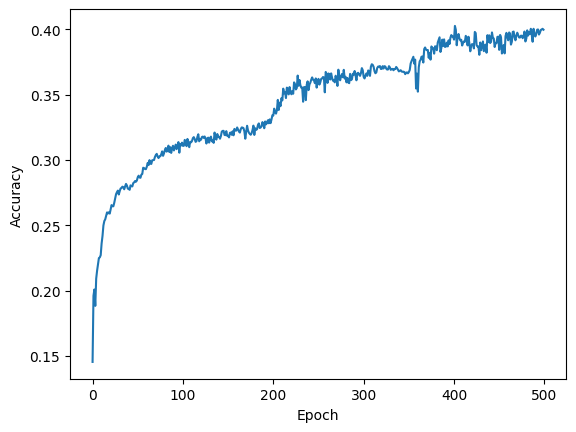

In [15]:
plt.plot(accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [24]:
X_train.shape

torch.Size([50000, 1024])

In [27]:
est_alpha_kd = mcbe.dd_mcbe(np.array(weights)[-1], X_train, num_estimation_points=100000, dd_method="kde")
print("done")
percent_inj_kd = mcbe.check_injectivity_naive(W = np.array(weights)[-1], b=est_alpha_kd, points=X_test[:1000,:],iter=X_test.shape[0])
percent_inj_kd

100%|██████████| 100000/100000 [16:14:48<00:00,  1.71it/s]       


done


0.82

In [17]:
num_iter = 10
num_estimation_points = 25000

inj_kd = []
inj_rd = []
inj_blowup = []
inj_mcbe = []
inj_og = []
inj_small_bias = []

for i in tqdm.tqdm(range(num_iter)):

    #kernel density estimation
    est_alpha_kd = mcbe.dd_mcbe(np.array(weights)[-1], X_train, num_estimation_points, dd_method="kd")
    percent_inj_kd = mcbe.check_injectivity_naive(W = np.array(weights)[-1], b=est_alpha_kd, points=X_test,iter=X_test.shape[0])
    inj_kd.append(percent_inj_kd)
    print("kernel done")

    #blown up data
    est_alpha_blowup = mcbe.dd_mcbe(np.array(weights)[-1], X_train,  num_estimation_points, dd_method="blowup")
    percent_inj_blowup = mcbe.check_injectivity_naive(W = np.array(weights)[-1], b=est_alpha_blowup, points=X_test,iter=X_test.shape[0])
    inj_blowup.append(percent_inj_blowup)
    print("blowup done")

    #mcbe
    est_alpha = mcbe.mcbe(polytope=np.array(weights)[-1],N=num_estimation_points,distribution="normal",radius=np.max(np.array(X_train)), sample_on_sphere=False)
    percent_inj = mcbe.check_injectivity_naive(W = np.array(weights)[-1], b=est_alpha, points=X_test,iter=X_test.shape[0])
    inj_mcbe.append(percent_inj)
    print("mcbe done")

  0%|          | 0/10 [00:00<?, ?it/s]

kernel done
blowup done


 10%|█         | 1/10 [41:27<6:13:09, 2487.73s/it]

mcbe done
kernel done
blowup done


 20%|██        | 2/10 [1:22:45<5:30:53, 2481.63s/it]

mcbe done


 20%|██        | 2/10 [1:36:16<6:25:06, 2888.37s/it]


KeyboardInterrupt: 

In [ ]:
#compare inj lists in boxplots
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.boxplot([inj_kd,inj_blowup,inj_mcbe],labels=["kd","blowup","mcbe"])
plt.title("percent of injectivity on test set for differnet bias estimation methods")